<a href="https://colab.research.google.com/github/tifat58/PET-2020/blob/master/pet_attack1_mnist%2Bfmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random

plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
device

device(type='cpu')

In [3]:
def get_target_label_idx(labels, targets, shots=5, test=False):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    final_list = []
    #Both if and else operations seem to be the same, what would be the purpose of this?
    for t in targets:
        if test:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
        else:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
    
    return final_list

def convert_label(x):

    if x >= 5:
        return x-5
    else:
        return x

In [8]:

from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST, FashionMNIST

import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):

    def __init__(self, root: str, name='MNIST', normal_class=[0,1,2,3,4,5,6,7,8,9]):
        super().__init__()

        self.root = root
        self.name = name
        self.normal_classes = tuple(normal_class)     

        transform = transforms.Compose([transforms.ToTensor()])
        if name == 'MNIST':
          train_set = MyMNIST(root=self.root, train=True, download=True,
                              transform=transform)
          
        elif name == 'FashionMNIST':
          train_set = MyFashionMNIST(root=self.root, train=True, download=True,
                              transform=transform)
          
        train_index = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes)
        random.shuffle(train_index)

        train_index_half_len = int(len(train_index)/2)
        shadow_set = Subset(train_set, train_index[0:train_index_half_len])
        target_set = Subset(train_set, train_index[train_index_half_len:])

        shadow_half_len = int(len(shadow_set)/2)
        print("shadow half len: ", shadow_half_len)
        self.shadow_train = Subset(shadow_set, list(range(0, shadow_half_len)))
        self.shadow_test = Subset (shadow_set, list(range(shadow_half_len, len(shadow_set))))

        target_half_len = int(len(target_set)/2)
        print("Target half len: ", target_half_len)
        self.target_train = Subset(target_set, list(range(0, target_half_len)))
        self.target_unknown = Subset(target_set, list(range(target_half_len, len(target_set))))


In [10]:
class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        # if self.train:
        #     img, target = self.train_data[index], self.train_labels[index]
        # else:
        #     img, target = self.test_data[index], self.test_labels[index]

        if self.train:
            img, target = self.data[index], self.targets[index]
        else:
            img, target = self.test_data[index], self.targets[index]

        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

In [11]:
class MyFashionMNIST(FashionMNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(FashionMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        # if self.train:
        #     img, target = self.train_data[index], self.train_labels[index]
        # else:
        #     img, target = self.test_data[index], self.test_labels[index]

        if self.train:
            img, target = self.data[index], self.targets[index]
        else:
            img, target = self.test_data[index], self.targets[index]

        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

**Section: MNIST Dataset**

In [14]:
mninst_dataset = MNIST_Dataset(root='data/', name='MNIST')
shadow_train_loader = DataLoader(mninst_dataset.shadow_train, batch_size=64, shuffle=True, num_workers=0)
shadow_test_loader = DataLoader(mninst_dataset.shadow_test, batch_size=64, shuffle=True, num_workers=0)
target_train_loader = DataLoader(mninst_dataset.target_train, batch_size=64, shuffle=True, num_workers=0)
target_unk_loader = DataLoader(mninst_dataset.target_unknown, batch_size=64, shuffle=True, num_workers=0)

shadow half len:  15000
Target half len:  15000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Labels:  tensor([9, 8, 6, 0, 3, 8, 6, 8])


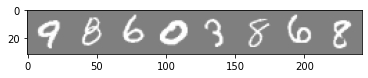

In [16]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(shadow_train_loader)
images, labels, idx = dataiter.next()
print("Labels: ", labels[0:8])

# show images
imshow(torchvision.utils.make_grid(images[0:8]))


In [17]:
""" This is the classifier model as mentioned in the paper
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 128)
        self.fc2   = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [18]:
""" Attack Model Implementation """

class AttackModel(nn.Module):
  def __init__(self, input_size, hidden_size):
      super(AttackModel, self).__init__()
      self.input_size = input_size
      self.hidden_size  = hidden_size

      self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
      self.fc2 = torch.nn.Linear(self.hidden_size, 2)
      # self.sigmoid = torch.nn.Softmax()

  def forward(self, x):
      x = self.fc1(x)
      x = F.softmax(self.fc2(x))
      output = x
      
      return output

In [19]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20, attack=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in train_loader:
                    if attack:
                      inputs, labels = data
                    else:
                      inputs, labels, idx = data

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
                        # print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    
                scheduler.step()
                print(running_corrects)
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
            else:
                
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in test_loader:
                    if attack:
                      inputs, labels = data
                    else:
                      inputs, labels, idx = data
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                last_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, best_acc, last_model_wts

In [20]:
""" Returns top3 prediction probability given x"""

def test(model, test_loader, criterion):
  model.eval()   # Set model to evaluate mode
                
  running_loss = 0.0
  running_corrects = 0
  # prediction_list = []
  i = 0
  for data in test_loader:
      inputs, labels, idx = data
      inputs = inputs.to(device)
      labels = labels.to(device)
     
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          sm = torch.nn.Softmax()
          pred_probs = sm(outputs)
          pred_probs, indices = torch.sort(pred_probs, descending=True)
          # print(pred_probs)
          if i == 0:
            prediction_list = pred_probs[:,0:3]
          else:
            prediction_list = torch.cat((prediction_list, pred_probs[:,0:3]))
          i += 1
          loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / test_size
  epoch_acc = running_corrects.double() / test_size

  print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
  
  return prediction_list

In [21]:
""" Attack model test function """
def attack_test(model, test_loader, criterion):
  model.eval()   # Set model to evaluate mode
                
  running_loss = 0.0
  running_corrects = 0
  # prediction_list = []
  i = 0
  test_true_label = []
  test_pred_label = []
  for data in test_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          sm = torch.nn.Softmax()
          pred_probs = sm(outputs)
          pred_probs, indices = torch.sort(pred_probs, descending=True)
          # # print(pred_probs)
          # if i == 0:
          #   prediction_list = pred_probs[:,0:3]
          # else:
          #   prediction_list = torch.cat((prediction_list, pred_probs[:,0:3]))
          # i += 1
          loss = criterion(outputs, labels)

          test_true_label.append(labels.data)
          test_pred_label.append(preds.data)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / test_size
  epoch_acc = running_corrects.double() / test_size

  print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
  
  return test_true_label, test_pred_label


In [39]:
"""Fuction to compute accuracy report"""
from sklearn.metrics import classification_report

def report(true_labels, predicted_labels):
  target_names = ['0','1']
  print(classification_report(true_labels, predicted_labels))
  from sklearn.metrics import confusion_matrix
  cm1 = confusion_matrix(true_labels, predicted_labels, labels=[1, 0])
      
  print("Confusion Matrix:")
  print(cm1)

  print('\nStatistical Report:')
  total1=sum(sum(cm1))
  #####from confusion matrix calculate accuracy
  accuracy1=(cm1[0,0]+cm1[1,1])/total1
  print ('Acc: ', round(accuracy1, 2))

  prec = cm1[0,0]/(cm1[0,0]+cm1[1,0])
  print('Precision: ', round(prec,2) )

  rec = cm1[0,0]/(cm1[0,0]+cm1[0,1])
  print('Recall: ', round(rec,2))

  return accuracy1, prec, rec



In [23]:
train_size = len(mninst_dataset.shadow_train)
test_size = len(mninst_dataset.shadow_test)
print(train_size, test_size)
net = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_net, best_acc, last_net = train_model(net, shadow_train_loader, shadow_test_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=30)

15000 15000
Epoch 0/29
----------
tensor(12308)
Train Loss: 0.5984 Acc: 0.8205
Val Loss: 0.2334 Acc: 0.9275

Epoch 1/29
----------
tensor(14181)
Train Loss: 0.1789 Acc: 0.9454
Val Loss: 0.1586 Acc: 0.9522

Epoch 2/29
----------
tensor(14452)
Train Loss: 0.1167 Acc: 0.9635
Val Loss: 0.1143 Acc: 0.9671

Epoch 3/29
----------
tensor(14586)
Train Loss: 0.0899 Acc: 0.9724
Val Loss: 0.0975 Acc: 0.9705

Epoch 4/29
----------
tensor(14647)
Train Loss: 0.0731 Acc: 0.9765
Val Loss: 0.0927 Acc: 0.9723

Epoch 5/29
----------
tensor(14722)
Train Loss: 0.0599 Acc: 0.9815
Val Loss: 0.0826 Acc: 0.9756

Epoch 6/29
----------
tensor(14786)
Train Loss: 0.0475 Acc: 0.9857
Val Loss: 0.0800 Acc: 0.9759

Epoch 7/29
----------
tensor(14879)
Train Loss: 0.0292 Acc: 0.9919
Val Loss: 0.0693 Acc: 0.9792

Epoch 8/29
----------
tensor(14894)
Train Loss: 0.0261 Acc: 0.9929
Val Loss: 0.0686 Acc: 0.9807

Epoch 9/29
----------
tensor(14910)
Train Loss: 0.0246 Acc: 0.9940
Val Loss: 0.0685 Acc: 0.9797

Epoch 10/29
------

In [25]:
print("Shadow model Test set predictions: ")
train_size = len(mninst_dataset.shadow_train)
test_size = len(mninst_dataset.shadow_test)
print(train_size, test_size)

s_net = LeNet().to(device)
s_net.load_state_dict(last_net)

shadow_test_prediction = test(s_net, shadow_test_loader, criterion)
print("Shadow model Train set predictions: ")
shadow_train_prediction = test(s_net, shadow_train_loader, criterion)

d1 = torch.utils.data.TensorDataset(shadow_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(shadow_test_prediction, torch.zeros(test_size, dtype=torch.long))
shadow_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(shadow_trained_dataset)

Shadow model Test set predictions: 
15000 15000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.0678 Acc: 0.9807
Shadow model Train set predictions: 
Val Loss: 0.0173 Acc: 0.9965


30000

In [28]:
print("Sample data: ", shadow_trained_dataset[17223][0], "label", shadow_trained_dataset[17223][1])

Sample data:  tensor([9.9997e-01, 2.1933e-05, 2.7650e-06]) label tensor(0)


In [27]:
""" Training Target model """
train_size = len(mninst_dataset.target_train)
test_size = len(mninst_dataset.target_unknown)
target_net = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(target_net.parameters(), lr=0.001, weight_decay=1e-07)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

target_best_net, target_best_acc, target_last_net = train_model(target_net, target_train_loader, target_unk_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=30)

Epoch 0/29
----------
tensor(12291)
Train Loss: 0.6317 Acc: 0.8194
Val Loss: 0.2185 Acc: 0.9364

Epoch 1/29
----------
tensor(14184)
Train Loss: 0.1791 Acc: 0.9456
Val Loss: 0.1194 Acc: 0.9632

Epoch 2/29
----------
tensor(14453)
Train Loss: 0.1214 Acc: 0.9635
Val Loss: 0.0942 Acc: 0.9713

Epoch 3/29
----------
tensor(14587)
Train Loss: 0.0899 Acc: 0.9725
Val Loss: 0.0791 Acc: 0.9757

Epoch 4/29
----------
tensor(14651)
Train Loss: 0.0745 Acc: 0.9767
Val Loss: 0.0773 Acc: 0.9762

Epoch 5/29
----------
tensor(14710)
Train Loss: 0.0614 Acc: 0.9807
Val Loss: 0.0691 Acc: 0.9783

Epoch 6/29
----------
tensor(14745)
Train Loss: 0.0515 Acc: 0.9830
Val Loss: 0.0622 Acc: 0.9805

Epoch 7/29
----------
tensor(14773)
Train Loss: 0.0457 Acc: 0.9849
Val Loss: 0.0687 Acc: 0.9785

Epoch 8/29
----------
tensor(14795)
Train Loss: 0.0400 Acc: 0.9863
Val Loss: 0.0555 Acc: 0.9829

Epoch 9/29
----------
tensor(14833)
Train Loss: 0.0334 Acc: 0.9889
Val Loss: 0.0677 Acc: 0.9795

Epoch 10/29
----------
tensor(

In [30]:
train_size = len(mninst_dataset.target_train)
test_size = len(mninst_dataset.target_unknown)

t_net = LeNet().to(device)
t_net.load_state_dict(target_last_net)

target_test_prediction = test(t_net, target_unk_loader, criterion)
target_train_prediction = test(t_net, target_train_loader, criterion)

d1 = torch.utils.data.TensorDataset(target_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(target_test_prediction, torch.zeros(test_size, dtype=torch.long))
target_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(target_trained_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.0799 Acc: 0.9837
Val Loss: 0.0023 Acc: 0.9992


30000

**Attack Model Training**

In [31]:
train_size = len(shadow_trained_dataset)
test_size = len(target_trained_dataset)
attack_model = AttackModel(3, 64).to(device)

atk_train_loader = DataLoader(shadow_trained_dataset, batch_size=10, shuffle=True, num_workers=0)
atk_test_loader = DataLoader(target_trained_dataset, batch_size=10, shuffle=True, num_workers=0)
optimizer_ft = optim.Adam(attack_model.parameters(), lr=0.01, weight_decay=1e-6)

attack_best_net, attack_best_acc, attack_last_net = train_model(attack_model, atk_train_loader, atk_test_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40, attack=True)

Epoch 0/39
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


tensor(14916)
Train Loss: 0.6947 Acc: 0.4972
Val Loss: 0.6920 Acc: 0.5000

Epoch 1/39
----------
tensor(15075)
Train Loss: 0.6944 Acc: 0.5025
Val Loss: 0.6926 Acc: 0.5088

Epoch 2/39
----------
tensor(15144)
Train Loss: 0.6947 Acc: 0.5048
Val Loss: 0.6924 Acc: 0.5085

Epoch 3/39
----------
tensor(15088)
Train Loss: 0.6938 Acc: 0.5029
Val Loss: 0.6928 Acc: 0.5080

Epoch 4/39
----------
tensor(15111)
Train Loss: 0.6942 Acc: 0.5037
Val Loss: 0.6958 Acc: 0.5000

Epoch 5/39
----------
tensor(15191)
Train Loss: 0.6941 Acc: 0.5064
Val Loss: 0.6932 Acc: 0.5000

Epoch 6/39
----------
tensor(15110)
Train Loss: 0.6938 Acc: 0.5037
Val Loss: 0.6916 Acc: 0.5095

Epoch 7/39
----------
tensor(15122)
Train Loss: 0.6946 Acc: 0.5041
Val Loss: 0.6931 Acc: 0.5074

Epoch 8/39
----------
tensor(15046)
Train Loss: 0.6943 Acc: 0.5015
Val Loss: 0.6917 Acc: 0.5106

Epoch 9/39
----------
tensor(15146)
Train Loss: 0.6943 Acc: 0.5049
Val Loss: 0.6930 Acc: 0.5078

Epoch 10/39
----------
tensor(14956)
Train Loss: 0.6

In [37]:
a_net = AttackModel(3, 64).to(device)
a_net.load_state_dict(attack_last_net)
t_l, t_p = attack_test(attack_best_net, atk_test_loader, criterion)
l_true = []
l_pred = []
for d in t_l:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_true.append(l)
# print(l_true)
for d in t_p:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_pred.append(l)
# print(l_pred)
mnist_acc, mnist_prec, mnist_rec = report(l_true, l_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.6917 Acc: 0.5110
              precision    recall  f1-score   support

           0       0.68      0.04      0.08     15000
           1       0.51      0.98      0.67     15000

    accuracy                           0.51     30000
   macro avg       0.59      0.51      0.37     30000
weighted avg       0.59      0.51      0.37     30000

Confusion Matrix:
[[14700   300]
 [14370   630]]

Statistical Report:
Acc:  0.51
Precision:  0.51
Recall:  0.98


**Section: Fashion MNIST Dataset**

In [41]:
fashion_mninst_dataset = MNIST_Dataset(root='data/', name='FashionMNIST')
shadow_train_loader = DataLoader(fashion_mninst_dataset.shadow_train, batch_size=64, shuffle=True, num_workers=0)
shadow_test_loader = DataLoader(fashion_mninst_dataset.shadow_test, batch_size=64, shuffle=True, num_workers=0)
target_train_loader = DataLoader(fashion_mninst_dataset.target_train, batch_size=64, shuffle=True, num_workers=0)
target_unk_loader = DataLoader(fashion_mninst_dataset.target_unknown, batch_size=64, shuffle=True, num_workers=0)

shadow half len:  15000
Target half len:  15000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Labels:  tensor([1, 0, 6, 8, 9, 1, 7, 1])


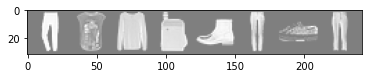

In [42]:

# get some random training images
dataiter = iter(shadow_train_loader)
images, labels, idx = dataiter.next()
print("Labels: ", labels[0:8])

# show images
imshow(torchvision.utils.make_grid(images[0:8]))

In [43]:
train_size = len(fashion_mninst_dataset.shadow_train)
test_size = len(fashion_mninst_dataset.shadow_test)
print(train_size, test_size)
fashion_net = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(fashion_net.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_net, best_acc, last_net = train_model(fashion_net, shadow_train_loader, shadow_test_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=30)

15000 15000
Epoch 0/29
----------
tensor(10190)
Train Loss: 0.9138 Acc: 0.6793
Val Loss: 0.6385 Acc: 0.7647

Epoch 1/29
----------
tensor(11846)
Train Loss: 0.5707 Acc: 0.7897
Val Loss: 0.5778 Acc: 0.7916

Epoch 2/29
----------
tensor(12421)
Train Loss: 0.4807 Acc: 0.8281
Val Loss: 0.4679 Acc: 0.8353

Epoch 3/29
----------
tensor(12662)
Train Loss: 0.4254 Acc: 0.8441
Val Loss: 0.4473 Acc: 0.8381

Epoch 4/29
----------
tensor(12852)
Train Loss: 0.3951 Acc: 0.8568
Val Loss: 0.4116 Acc: 0.8492

Epoch 5/29
----------
tensor(13061)
Train Loss: 0.3645 Acc: 0.8707
Val Loss: 0.3845 Acc: 0.8609

Epoch 6/29
----------
tensor(13170)
Train Loss: 0.3456 Acc: 0.8780
Val Loss: 0.4066 Acc: 0.8533

Epoch 7/29
----------
tensor(13342)
Train Loss: 0.3109 Acc: 0.8895
Val Loss: 0.3588 Acc: 0.8711

Epoch 8/29
----------
tensor(13384)
Train Loss: 0.3034 Acc: 0.8923
Val Loss: 0.3553 Acc: 0.8729

Epoch 9/29
----------
tensor(13380)
Train Loss: 0.3003 Acc: 0.8920
Val Loss: 0.3541 Acc: 0.8730

Epoch 10/29
------

In [44]:
print("Shadow model Test set predictions: ")
train_size = len(mninst_dataset.shadow_train)
test_size = len(mninst_dataset.shadow_test)
print(train_size, test_size)

s_net = LeNet().to(device)
s_net.load_state_dict(last_net)

shadow_test_prediction = test(s_net, shadow_test_loader, criterion)
print("Shadow model Train set predictions: ")
shadow_train_prediction = test(s_net, shadow_train_loader, criterion)

d1 = torch.utils.data.TensorDataset(shadow_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(shadow_test_prediction, torch.zeros(test_size, dtype=torch.long))
shadow_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(shadow_trained_dataset)

Shadow model Test set predictions: 
15000 15000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.3473 Acc: 0.8762
Shadow model Train set predictions: 
Val Loss: 0.2834 Acc: 0.9005


30000

In [46]:
""" Training Target model """
train_size = len(fashion_mninst_dataset.target_train)
test_size = len(fashion_mninst_dataset.target_unknown)
fashion_target_net = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(fashion_target_net.parameters(), lr=0.001, weight_decay=1e-07)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

target_best_net, target_best_acc, target_last_net = train_model(fashion_target_net, target_train_loader, target_unk_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=30)

Epoch 0/29
----------
tensor(10250)
Train Loss: 0.8902 Acc: 0.6833
Val Loss: 0.6269 Acc: 0.7603

Epoch 1/29
----------
tensor(11792)
Train Loss: 0.5736 Acc: 0.7861
Val Loss: 0.5329 Acc: 0.8036

Epoch 2/29
----------
tensor(12299)
Train Loss: 0.4945 Acc: 0.8199
Val Loss: 0.4828 Acc: 0.8216

Epoch 3/29
----------
tensor(12551)
Train Loss: 0.4522 Acc: 0.8367
Val Loss: 0.4415 Acc: 0.8417

Epoch 4/29
----------
tensor(12766)
Train Loss: 0.4200 Acc: 0.8511
Val Loss: 0.4158 Acc: 0.8519

Epoch 5/29
----------
tensor(12903)
Train Loss: 0.3921 Acc: 0.8602
Val Loss: 0.4189 Acc: 0.8459

Epoch 6/29
----------
tensor(13039)
Train Loss: 0.3657 Acc: 0.8693
Val Loss: 0.3838 Acc: 0.8613

Epoch 7/29
----------
tensor(13099)
Train Loss: 0.3531 Acc: 0.8733
Val Loss: 0.3804 Acc: 0.8633

Epoch 8/29
----------
tensor(13195)
Train Loss: 0.3349 Acc: 0.8797
Val Loss: 0.3600 Acc: 0.8711

Epoch 9/29
----------
tensor(13274)
Train Loss: 0.3199 Acc: 0.8849
Val Loss: 0.4014 Acc: 0.8584

Epoch 10/29
----------
tensor(

In [47]:
train_size = len(fashion_mninst_dataset.target_train)
test_size = len(fashion_mninst_dataset.target_unknown)

t_net = LeNet().to(device)
t_net.load_state_dict(target_last_net)

target_test_prediction = test(t_net, target_unk_loader, criterion)
target_train_prediction = test(t_net, target_train_loader, criterion)

d1 = torch.utils.data.TensorDataset(target_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(target_test_prediction, torch.zeros(test_size, dtype=torch.long))
target_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(target_trained_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.3718 Acc: 0.8847
Val Loss: 0.1189 Acc: 0.9593


30000

In [48]:
train_size = len(shadow_trained_dataset)
test_size = len(target_trained_dataset)
fashion_attack_model = AttackModel(3, 64).to(device)

atk_train_loader = DataLoader(shadow_trained_dataset, batch_size=64, shuffle=True, num_workers=0)
atk_test_loader = DataLoader(target_trained_dataset, batch_size=64, shuffle=True, num_workers=0)
optimizer_ft = optim.Adam(fashion_attack_model.parameters(), lr=0.01, weight_decay=1e-6)

attack_best_net, attack_best_acc, attack_last_net = train_model(fashion_attack_model, atk_train_loader, atk_test_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40, attack=True)

Epoch 0/39
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


tensor(14867)
Train Loss: 0.6953 Acc: 0.4956
Val Loss: 0.6933 Acc: 0.5000

Epoch 1/39
----------
tensor(15144)
Train Loss: 0.6939 Acc: 0.5048
Val Loss: 0.6928 Acc: 0.5131

Epoch 2/39
----------
tensor(14959)
Train Loss: 0.6936 Acc: 0.4986
Val Loss: 0.6933 Acc: 0.5000

Epoch 3/39
----------
tensor(15010)
Train Loss: 0.6935 Acc: 0.5003
Val Loss: 0.6933 Acc: 0.4846

Epoch 4/39
----------
tensor(14960)
Train Loss: 0.6937 Acc: 0.4987
Val Loss: 0.6935 Acc: 0.5000

Epoch 5/39
----------
tensor(15116)
Train Loss: 0.6936 Acc: 0.5039
Val Loss: 0.6933 Acc: 0.5000

Epoch 6/39
----------
tensor(15093)
Train Loss: 0.6935 Acc: 0.5031
Val Loss: 0.6928 Acc: 0.5000

Epoch 7/39
----------
tensor(14954)
Train Loss: 0.6937 Acc: 0.4985
Val Loss: 0.6930 Acc: 0.5169

Epoch 8/39
----------
tensor(14956)
Train Loss: 0.6938 Acc: 0.4985
Val Loss: 0.6935 Acc: 0.5000

Epoch 9/39
----------
tensor(14929)
Train Loss: 0.6936 Acc: 0.4976
Val Loss: 0.6930 Acc: 0.5084

Epoch 10/39
----------
tensor(14875)
Train Loss: 0.6

In [49]:
a_net = AttackModel(3, 64).to(device)
a_net.load_state_dict(attack_last_net)
t_l, t_p = attack_test(attack_best_net, atk_test_loader, criterion)
l_true = []
l_pred = []
for d in t_l:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_true.append(l)
# print(l_true)
for d in t_p:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_pred.append(l)
# print(l_pred)
f_mnist_acc, f_mnist_prec, f_mnist_rec = report(l_true, l_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.6930 Acc: 0.5169
              precision    recall  f1-score   support

           0       0.53      0.28      0.37     15000
           1       0.51      0.76      0.61     15000

    accuracy                           0.52     30000
   macro avg       0.52      0.52      0.49     30000
weighted avg       0.52      0.52      0.49     30000

Confusion Matrix:
[[11338  3662]
 [10830  4170]]

Statistical Report:
Acc:  0.52
Precision:  0.51
Recall:  0.76


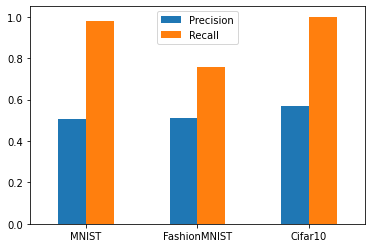

In [54]:
precision_list = [mnist_prec, f_mnist_prec, 0.57] # manually added precision value acheived in other script for cifar10
recall_list = [mnist_rec, f_mnist_rec, 1.0] # manually added recall value acheived in other script for cifar10
index = ['MNIST', 'FashionMNIST', 'Cifar10']
df = pd.DataFrame({'Precision': precision_list,
                   'Recall': recall_list}, index=index)
ax = df.plot.bar(rot=0)